<a id="primero"></a>
## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />

Descargue los datos de la página de Kaggle y cárguelos mediante pandas.

In [28]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [1]:
df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [2]:
df_ner

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


---

a) En esta primera instancia trabajaremos con la tarea de realizar un NER tag (Named Entity Recognition) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo many to many, es decir, la entrada es una secuencia y la salida es una secuencia, sin shift, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar lemma en vez de la palabra misma word?

In [3]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

In [4]:
dataset

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O
5,through,through,IN,O,O
6,london,London,NNP,B-geo,O
7,to,to,TO,O,B-geo
8,protest,protest,VB,O,O
9,the,the,DT,O,O


Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los las etiquetas (tags), esto es un arreglo de arreglos de lemmas y un arreglo de arreglos de tags respectivamente. ¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?

In [195]:
dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
sentence = []
labels_sentence = []
for fila in dataset.values:
    if fila[-1]=="__START1__":  
        #print(sentence)
        if len(sentence) > 0:
            #print("here")
            dataX.append(np.asarray(sentence))
            dataY.append(np.asarray(labels_sentence))
        sentence = []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = np.asarray(dataX[:]) #data to  array
dataY = np.asarray(dataY[:])

Debido a que los datos corresponden a las sentencias extraídas del corpus, y tomando cada dato como el conjunto de palabras que componen la sentencia, es claro que la dimensión de los datos es variable, ya que el largo de las sentencias no siempre es el mismo. En el próximo punto estudiaremos la distribución del largo de las sentencias.

---

b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

In [26]:
sentence_lengths = list(map(len, dataX))

In [56]:
def map_to_dict(word):
    try:
        vocabulary[word] += 1
    except:
        vocabulary[word] = 1

vocabulary = {}

for i in range(len(dataX)):
    list(map(map_to_dict,dataX[i]))        

In [69]:
freqs = [count for word, count in vocabulary.items()]
freqs.sort(reverse=True)

In [78]:
def map_to_dict(word):
    try:
        classes[word] += 1
    except:
        classes[word] = 1

classes = {}

for i in range(len(dataY)):
    list(map(map_to_dict,dataY[i]))  

In [94]:
classes = []
frequencies = []

for word, count in vocabulary.items():
    classes.append(word)
    frequencies.append(count)


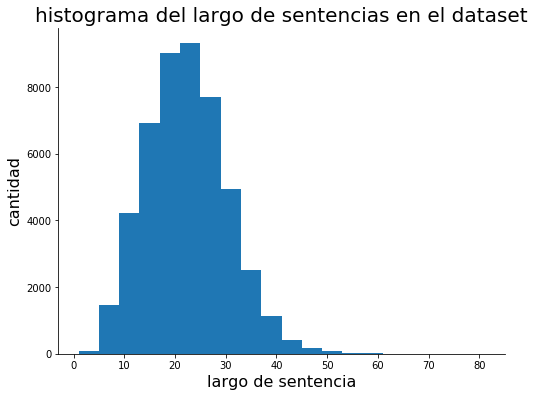

In [34]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
plt.hist(sentence_lengths, bins = 20)
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("cantidad", fontsize=16)
plt.xlabel("largo de sentencia", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('histograma del largo de sentencias en el dataset', fontsize=20)

plt.show()

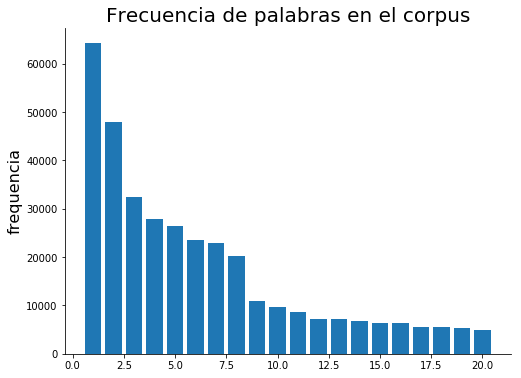

In [75]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
plt.bar(np.arange(1,21),freqs[:20])
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("frequencia", fontsize=16)
#plt.xlabel("largo de sentencia", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('Frecuencia de palabras en el corpus', fontsize=20)

plt.show()

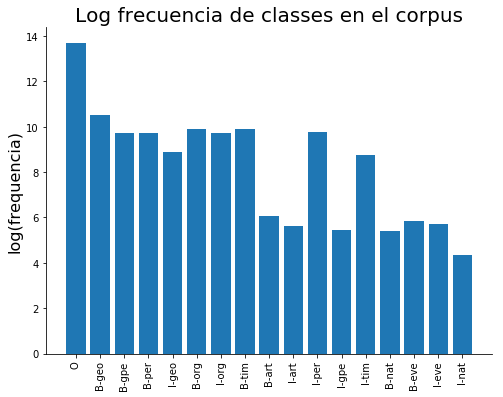

In [102]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
plt.bar(classes,np.log(frequencies))
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("log(frequencia)", fontsize=16)
#plt.xlabel("largo de sentencia", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('Log frecuencia de classes en el corpus', fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

---

c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo que será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. **Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas**. Además de esto, debido al largo distinto de las sentencias se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*0, 0*].

In [200]:
lemma2idx = {w: i+1 for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i+1 for i, t in enumerate(labels)}
X = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
Y = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

In [198]:
max_input_length = np.max(sentence_lengths)

---

d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece más conveniente al rellenar con un valor especial respecto al cómo funciona una red recurrente y cómo funciona su memoria **¿Al principio o al final de la sentencia?** Comente

In [219]:
from keras.preprocessing import sequence
X = sequence.pad_sequences(X,maxlen=max_input_length,padding='pre',value=0) 
Y = sequence.pad_sequences(Y,maxlen=max_input_length,padding='pre',value=0)

---

e) Para el poder entregar una clasificación sobre los distintos *tags* es necesario tranformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [220]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train_n, y_test_n = train_test_split(X, Y, test_size=0.3,random_state=22)

from keras.utils import to_categorical
y_train = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_train_n])
y_test = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_test_n])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_n, y_test_n = train_test_split(X, Y, test_size=0.3,random_state=22)

def map_to_dict(word):
    try:
        classes[word] += 1
    except:
        classes[word] = 1

classes = {}

for i in range(len(y_test_n)):
    list(map(map_to_dict,y_test_n[i])) 
    
classes = []
frequencies = []

for word, count in vocabulary.items():
    classes.append(word)
    frequencies.append(count)


In [ ]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
plt.bar(classes,np.log(frequencies))
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("log(frequencia)", fontsize=16)
#plt.xlabel("largo de sentencia", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('Log frecuencia de classes en el corpus', fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

---

f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

In [208]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_length))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels+1, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
lstm_29 (LSTM)               (None, 81, 100)           53200     
_________________________________________________________________
dense_23 (Dense)             (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________


In [239]:
relevant_index = np.argwhere(y_test_n.flatten() != 0)
relevant_y = y_test_n.flatten()[relevant_index] 
relevant_predicted = model.predict_classes(X_test,verbose=0).flatten()[relevant_index] 

In [251]:
from sklearn.metrics import f1_score
score = f1_score(relevant_y-1,relevant_predicted-1, average='weighted')

0.18431582302640342

In [250]:
np.sum(relevant_y == 4)

5960

---

g) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

In [ ]:
embeddings = [16, 32, 64, 128]

for embedding_vector in embeddings:
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_length))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dense(n_labels+1, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

---

h) Use *Dropout* para entrenar la LSTM. **¿El *Dropout* mejora el desempeño de la red?** Señale cuáles podrı́an ser las causas del comportamiento observado.

In [ ]:
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels+1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

---

i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode=concatenate))
model.add(Dense(n_labels+1, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

---

j) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. **Entrene la red definida en f) y compare al utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el *default* de la capa *embedding***, comente sobre las curvas de entrenamiento y los tiempos de entrenamiento.

---

k) En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras.

---

l) Utilice la red entranda anteriormente, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.  

---

m) **Carge las palabras del dataset** ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). **Utilice el tamaño del *corpus* que le acomode a la memoria de su computador**.

---

n) **Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres**, tal cual se realizó en c) con los *lemmas*, **lo mismo para las etiquetas**. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. **Transforme las etiquetas a *one hot vector*** como se realizó en c) y **defina la red** similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA)[[2]](#refs) para *Deep Neural Network*. 

---

o) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente **¿Cuál es la técnica para predecir el siguiente carácter?**

---

p) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. **Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.**